Librerias

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import glob
import netCDF4 as nc
from matplotlib.colors import LinearSegmentedColormap
from dateutil.relativedelta import relativedelta
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
import fiona
from zipfile import ZipFile
import cdsapi
import warnings
warnings.filterwarnings('ignore')

Funciones

In [2]:
def Daylight(latitude,day):
    
    import math
    
    P = math.asin(0.39795 * math.cos(0.2163108 + 2 * math.atan(0.9671396 * math.tan(.00860 * (day - 186)))))
    pi = math.pi
    daylightamount = 24 - (24 / pi) * math.acos((math.sin((0.8333 * pi / 180) + math.sin(latitude * pi / 180) * math.sin(P)) / (math.cos(latitude * pi / 180) * math.cos(P))))
    
    return daylightamount

def cortar_serie_matriz(serie, lats, lons, latmin, latmax, lonmin, lonmax):

    import numpy as np

    donde_lat =np.where((lats >= latmin) & (lats <= latmax))[0]
    donde_lon = np.where((lons >= lonmin) & (lons <= lonmax))[0]
    latitud_region = lats[donde_lat]
    longitud_region = lons[donde_lon]

    serie = serie[:,donde_lat,:]
    serie = serie[:,:,donde_lon]

    return (serie, latitud_region, longitud_region)

def regrid(data, rows_out, columns_out):

    from scipy.interpolate import RegularGridInterpolator
    import numpy as np

    m = max(data.shape[0], data.shape[1])
    y = np.linspace(0, 1.0/m, data.shape[0])
    x = np.linspace(0, 1.0/m, data.shape[1])
    interpolating_function = RegularGridInterpolator((y, x), data)

    yv, xv = np.meshgrid(np.linspace(0, 1.0/m, columns_out), np.linspace(0, 1.0/m,rows_out))

    return interpolating_function((xv, yv))

IDH

In [3]:
def VR(p, etp, r1, rmax=100):
    
    tmp = (r1/(rmax+(etp-p)/2))*(etp-p)
    
    if p > etp:
        vr = 0
    elif tmp > r1:
        vr = r1
    else:
        vr = tmp
        
    return vr

def R(p, etp, r1, vr, rmax=100):
    
    if p < etp:
        r = r1-vr
    elif r1+(p-etp) > rmax:
        r = rmax
    else:
        r = r1+(p-etp)
        
    return r

def ET(p, etp, vr):
    
    if p < etp:
        et = p+vr
    else:
        et = etp
        
    return et

def EX(p, etp, r1, rmax=100):
    
    if r1+(p-etp) > rmax:
        ex = r1+(p-etp)-rmax
    else:
        ex = 0
    
    return ex

def IDH(et, ex, etp):
    
    idh = 100*(et+0.25*ex)/etp
    
    return idh

Parametros de entrada

In [4]:
file_name = 'Cultivo_1'
fecha_ini = '2015-08-24'
fecha_fin = '2016-02-11'

Rutas

In [5]:
ruta_cultivos = './Data/Cultivos/'
ruta_IMERG = './Data/IMERG/'
ruta_temp = './Data/Temperatura/'

Leer geometria del cultivo en formato kmz

In [6]:
fiona.drvsupport.supported_drivers['kml'] = 'rw'
fiona.drvsupport.supported_drivers['KML'] = 'rw'

kmz = ZipFile(ruta_cultivos + file_name + '.kmz', 'r')
kmz.extract('doc.kml', ruta_cultivos)

cultivo = gpd.read_file(os.path.join(ruta_cultivos, 'doc.kml'))

lat_min = np.round(cultivo.bounds['miny'][0]-5, 2)
lat_max = np.round(cultivo.bounds['maxy'][0]+5, 2)
lon_min = np.round(cultivo.bounds['minx'][0]-5, 2)
lon_max = np.round(cultivo.bounds['maxx'][0]+5, 2)

Fechas de analisis

In [7]:
fecha_cal_i = dt.datetime.strptime(fecha_ini,'%Y-%m-%d') - dt.timedelta(days=60)
fecha_cal_f = dt.datetime.strptime(fecha_fin,'%Y-%m-%d') + relativedelta(months=1)
fechas_analisis = pd.date_range(fecha_cal_i.strftime('%Y/%m/01'), fecha_cal_f.strftime('%Y/%m/01'))
fechas_analisis = fechas_analisis[:-1]

Descaragr datos de precipitación IMERG

In [8]:
url_IMERG = 'https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGDE.06/'
urls      = []
for i in fechas_analisis:
    tmp = url_IMERG + i.strftime('%Y/%m') + '/3B-DAY-E.MS.MRG.3IMERG.'
    urls.append(tmp + i.strftime('%Y%m%d') + '-S000000-E235959.V06.nc4')
user, password = 'proyectounal2015', 'Proyectounal2015'
for url in urls[:]:
    print('Descargando...')
    print(url)
    os.system('wget -P ' + ruta_IMERG + ' --user ' + user + ' --password ' + password + ' ' + url)

Descargar datos de temperatura ERA5

In [9]:
area = str(lat_max) + '/' + str(lon_min) + '/' + str(lat_min) + '/' + str(lon_max)

ini = (fechas_analisis[0]-dt.timedelta(days=60)).strftime('%Y/%m/01')
fin = (fechas_analisis[-1]+dt.timedelta(days=61)).strftime('%Y/%m/01')

fechas_era5 = pd.date_range(ini, fin, freq='MS')

for fecha in fechas_era5[:]:
    year  = fecha.strftime('%Y')
    month = fecha.strftime('%m')
    day   = fecha.strftime('%d')
    c = cdsapi.Client()
    c.retrieve(
    'reanalysis-era5-land-monthly-means',
        {
            'variable': ['2m_temperature'],
            'year': year,
            'month': month,
            'time': '00:00',
            'format': 'netcdf',
            'area':area
        },
        ruta_temp+str(year)+str(month)+str(day)+'.nc')

Precipitación

In [10]:
archivos = sorted(glob.glob(ruta_IMERG+'*.nc4'))

ppt = []
fechas_ppt = []

for i in range(len(archivos))[:]:
    dataset = nc.Dataset(archivos[i])
    tmp = np.array(dataset.variables['precipitationCal'])[0].T
    ppt.append(cortar_serie_matriz(np.array([tmp]), np.array(dataset.variables['lat']), np.array(dataset.variables['lon']), 
                                   lat_min,
                                   lat_max,
                                   lon_min,
                                   lon_max)[0][0])
    fechas_ppt.append(dt.datetime(1970,1,1,0,0,0)+dt.timedelta(days=np.array(dataset.variables['time'])[0]))
    if i == 0:
        lat_ppt = cortar_serie_matriz(np.array([tmp]), np.array(dataset.variables['lat']), np.array(dataset.variables['lon']), 
                                      lat_min,
                                      lat_max,
                                      lon_min,
                                      lon_max)[1]
        lon_ppt = cortar_serie_matriz(np.array([tmp]), np.array(dataset.variables['lat']), np.array(dataset.variables['lon']),
                                      lat_min,
                                      lat_max,
                                      lon_min,
                                      lon_max)[2]
    dataset.close()
    
fechas_ppt = pd.Index(fechas_ppt)
ppt = np.array(ppt)

PPT decadal

In [11]:
tmp = np.unique(fechas_ppt.strftime('%Y/%m'))

ppt_dec = []
fechas_ppt_dec = []
for i in range(len(tmp))[:]:
    pos = np.where(fechas_ppt.strftime('%Y/%m') == tmp[i])[0]
    ppt_mes = ppt[pos,:,:]
    fechas_mes = fechas_ppt[pos]
    g1 = np.where(fechas_mes.day<11)[0]
    g2 = np.where((fechas_mes.day>=11)&(fechas_mes.day<21))[0]
    g3 = np.where(fechas_mes.day>=21)[0]
    
    ppt_dec.append(np.nansum(ppt_mes[g1,:,:], axis=0)) 
    ppt_dec.append(np.nansum(ppt_mes[g2,:,:], axis=0)) 
    ppt_dec.append(np.nansum(ppt_mes[g3,:,:], axis=0))
    fechas_ppt_dec.append(fechas_mes[g1[0]])
    fechas_ppt_dec.append(fechas_mes[g2[0]])
    fechas_ppt_dec.append(fechas_mes[g3[0]])
    
ppt_dec = np.array(ppt_dec)
fechas_ppt_dec = pd.Index(fechas_ppt_dec)

Evapotranspiración potencial (Thornthwaite)

In [12]:
archivos = sorted(glob.glob(ruta_temp+'/*.nc'))[:]

t2 = []
fechas_t2 = []
for i in range(len(archivos))[:]:
    dataset = nc.Dataset(archivos[i])
    t2.append(np.array(dataset.variables['t2m'])[0])
    fechas_t2.append(dt.datetime(1900,1,1,0,0,0)+dt.timedelta(hours=np.int(np.array(dataset.variables['time'])[0])))
    if i == 0:
        lat_t2 = np.array(dataset.variables['latitude'])
        lon_t2 = np.array(dataset.variables['longitude'])
    dataset.close()
t2 = np.array(t2)
t2[t2==-32767] = np.nan
t2 = t2 - 273.15

lat_t2 = lat_t2[::-1]
t2 = t2[:,::-1,:]

I = np.nansum((t2/5)**1.514, axis=0)
a = 675e-9*I**3 - 771e-7*I**2 +1792e-5*I + 0.49239
etp = 16*(10*t2/I)**a
fechas_etp = np.copy(fechas_t2) 
lat_etp = np.copy(lat_t2)
lon_etp = np.copy(lon_t2)

julian_day = []
for i in fechas_era5:
    julian_day.append(i.timetuple().tm_yday)
    
for mes in range(len(julian_day))[:]:
    for latitud in range(len(lat_etp))[:]:
        etp[mes][latitud] = etp[mes][latitud] * Daylight(lat_etp[latitud], julian_day[mes]) / 12

ETP decadal

In [13]:
etp_dec = []
fechas_etp_dec = []

for i in range(etp.shape[0]-2):
    etp_dec.append((etp[i]+2*etp[i+1])/3)
    etp_dec.append(etp[i+1])
    etp_dec.append((etp[i+2]+2*etp[i+1])/3)
    
    fechas_etp_dec.append(fechas_etp[i+1].strftime('%Y-%m-01'))
    fechas_etp_dec.append(fechas_etp[i+1].strftime('%Y-%m-11'))
    fechas_etp_dec.append(fechas_etp[i+1].strftime('%Y-%m-21'))

etp_dec = np.array(etp_dec)
fechas_etp_dec = pd.to_datetime(fechas_etp_dec)

Igualando dimensiones

In [14]:
lat_min = max(min(lat_etp), min(lat_ppt))
lat_max = min(max(lat_etp), max(lat_ppt))
lon_min = max(min(lon_etp), min(lon_ppt))
lon_max = min(max(lon_etp), max(lon_ppt))

ppt_dec, lat_ppt, lon_ppt = cortar_serie_matriz(ppt_dec, lat_ppt, lon_ppt, lat_min, lat_max, lon_min, lon_max)
etp_dec, lat_etp, lon_etp = cortar_serie_matriz(etp_dec, lat_etp, lon_etp, lat_min, lat_max, lon_min, lon_max)

ETP = []
for i in range(len(etp_dec)):
    ETP.append(regrid(etp_dec[i], len(lat_ppt), len(lon_ppt)))
ETP = np.array(ETP)
PPT = ppt_dec
LAT = lat_ppt
LON = lon_ppt

ini = max(fechas_ppt_dec[0], fechas_etp_dec[0])
fin = min(fechas_ppt_dec[-1], fechas_etp_dec[-1])

ETP = ETP[np.where(fechas_etp_dec==ini)[0][0]:np.where(fechas_etp_dec==fin)[0][0], :, :]*(1/3)
PPT = PPT[np.where(fechas_ppt_dec==ini)[0][0]:np.where(fechas_ppt_dec==fin)[0][0], :, :]

fechas_etp_dec = fechas_etp_dec[np.where(fechas_etp_dec==ini)[0][0]:np.where(fechas_etp_dec==fin)[0][0]]
fechas_ppt_dec = fechas_ppt_dec[np.where(fechas_ppt_dec==ini)[0][0]:np.where(fechas_ppt_dec==fin)[0][0]]

Cálculo IDH

In [16]:
Indice_Disponibilidad_Hidrica = []

for ilat in range(len(LAT))[:]:
    
    tmp = []
    
    for ilon in range(len(LON))[:]:
        
        serie_ppt = PPT[:, ilat, ilon]
        serie_etp = ETP[:, ilat, ilon]
        
        indice = []

        for i in range(len(fechas_ppt_dec))[:]:
            
            p   = serie_ppt[i]
            etp = serie_etp[i]

            if i == 0:
                r1 = 100
            else:
                r1 = r

            vr = VR(p, etp, r1)
            r  = R(p, etp, r1, vr)
            et = ET(p, etp, vr)
            ex = EX(p, etp, r1)

            idh = IDH(et, ex, etp)
            indice.append(idh)

        tmp.append(indice)
        
    Indice_Disponibilidad_Hidrica.append(tmp)

Indice_Disponibilidad_Hidrica = np.array(Indice_Disponibilidad_Hidrica)

Mapas región

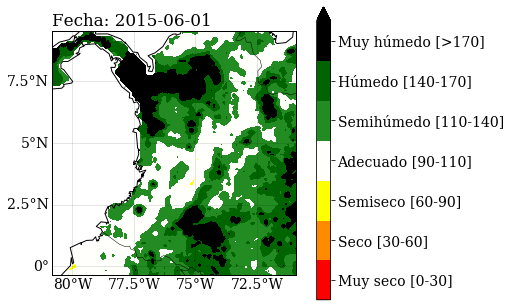

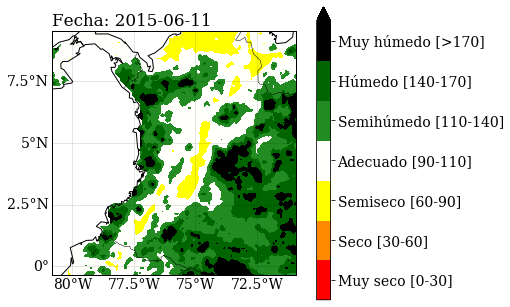

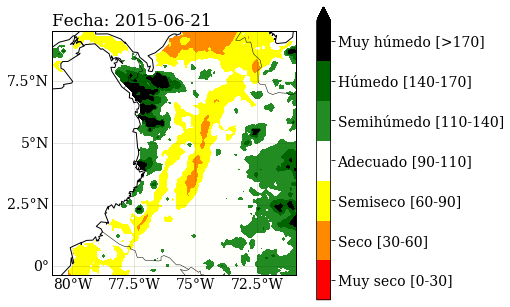

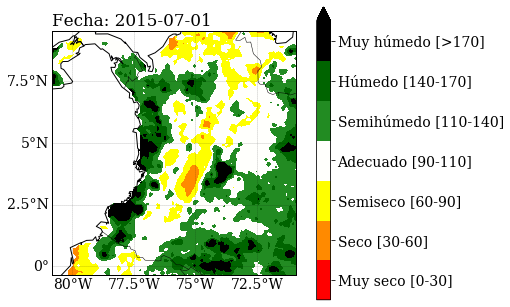

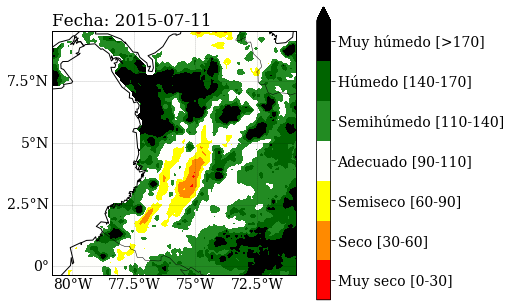

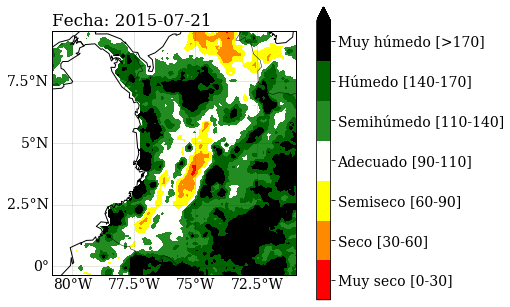

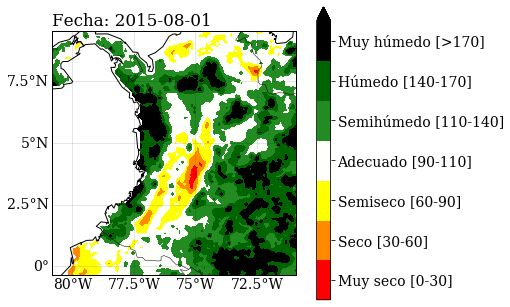

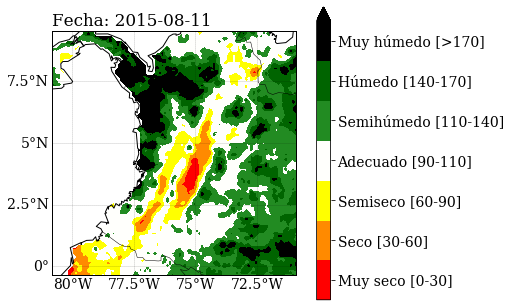

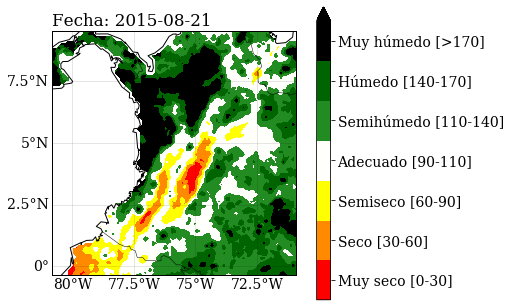

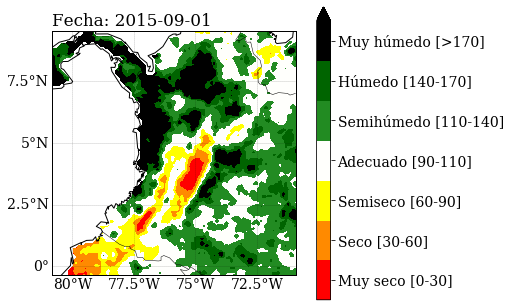

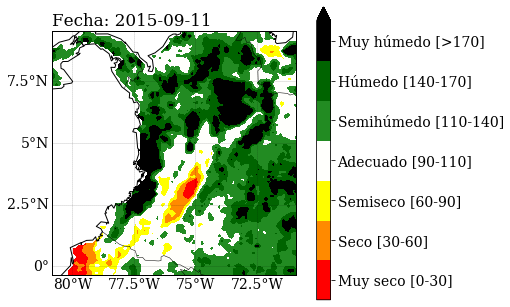

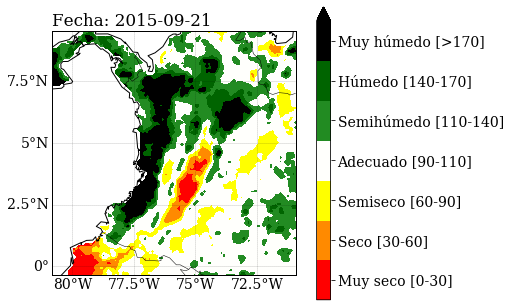

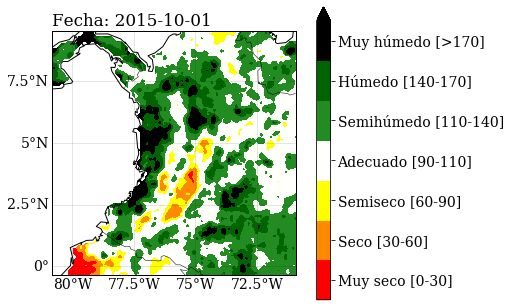

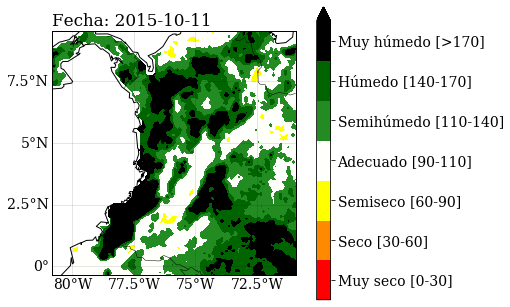

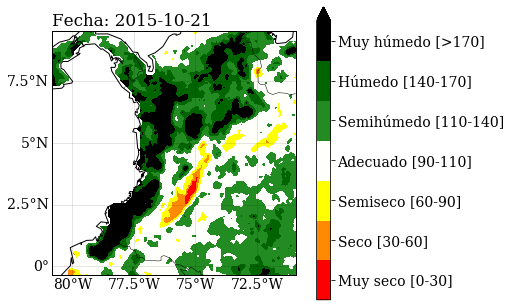

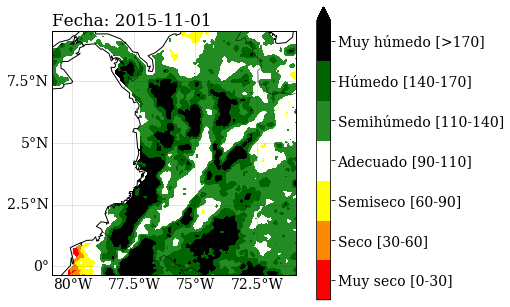

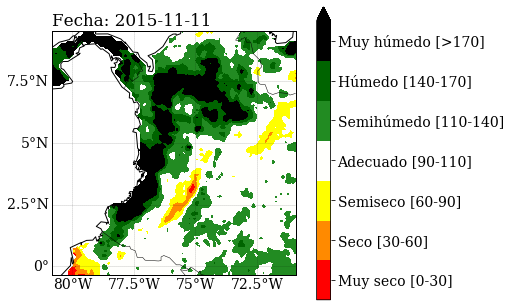

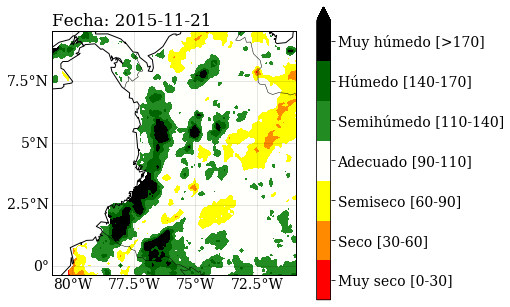

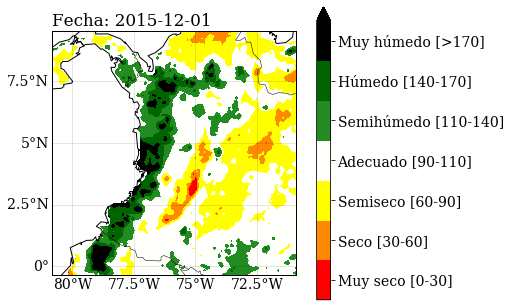

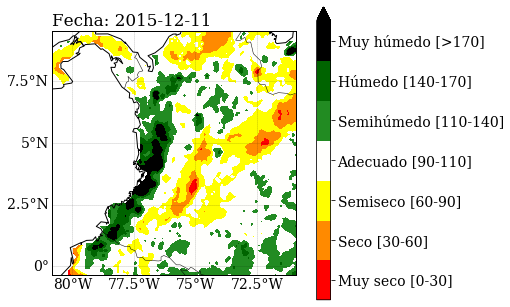

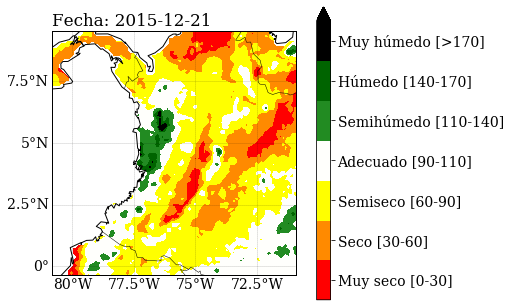

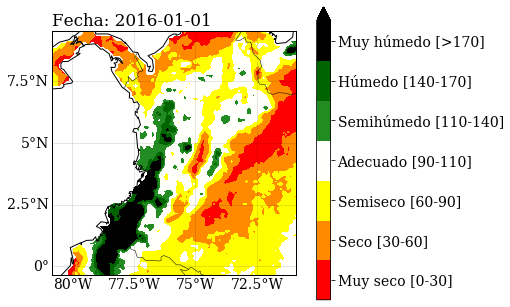

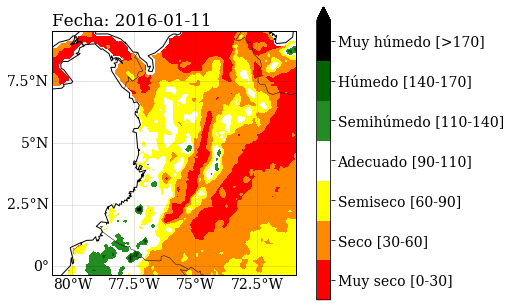

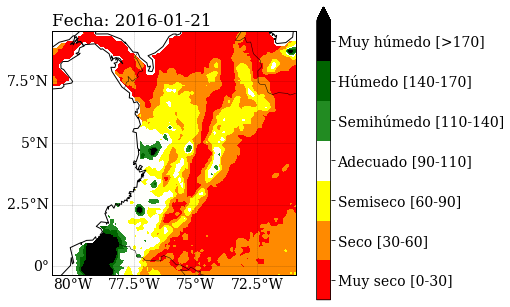

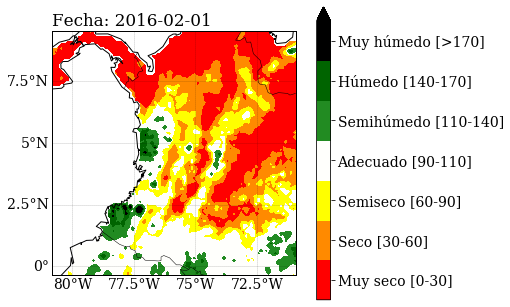

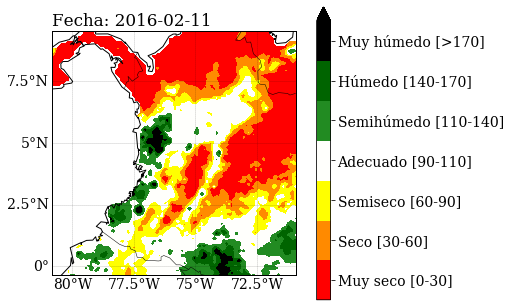

In [17]:
for date in range(len(fechas_etp_dec)):
    
    plt.figure(figsize=(5,8))

    csfont = {'fontname':'serif', 'size':15,'weight' : 500}
    mpl.rcParams['font.family'] = 'serif'
    mpl.rcParams['font.size'] = 14

    plt.title('Fecha: ' + fechas_etp_dec[date].strftime('%Y-%m-%d'), loc='left')

    m = Basemap(llcrnrlat=lat_min, urcrnrlat=lat_max, llcrnrlon=lon_min, urcrnrlon=lon_max, resolution='l')
    m.drawparallels(np.arange(-90.,90, 2.5), labels=[1,0,0,0], size=14,linewidth=0.2)
    m.drawmeridians(np.arange(0, 360, 2.5),labels=[0,1,0,1], size=14, linewidth=0.2)

    m.drawcoastlines()
    m.drawmapboundary()
    m.drawcountries()

    labels = ['Muy seco [0-30]', 'Seco [30-60]', 'Semiseco [60-90]', 'Adecuado [90-110]', 'Semihúmedo [110-140]', 'Húmedo [140-170]', 'Muy húmedo [>170]']
    clevs = [0,30,60,90,110,140,170, 200]

    x, y = np.meshgrid(LON, LAT)

    norm = mpl.colors.BoundaryNorm(boundaries=clevs, ncolors=256)
    cm = LinearSegmentedColormap.from_list('my_cmap', ['red', 'darkorange', 'yellow', 'white', 'forestgreen', 'darkgreen', 'black'])
    plt.contourf(x, y, Indice_Disponibilidad_Hidrica[:,:,date], clevs, cmap=cm, norm=norm, extend='max')

    cbar = plt.colorbar(orientation='vertical', fraction=0.05, pad=0.075)
    cbar.set_ticks([15,45,75,100,125,155,185])
    cbar.set_ticklabels(labels)
    plt.show()

Serie pixel más cercano

In [17]:
x_cen, y_cen = cultivo.centroid[0].xy[0][0], cultivo.centroid[0].xy[1][0]

IDH_pixel = Indice_Disponibilidad_Hidrica[np.where(np.abs(LAT-y_cen)==np.min(np.abs(LAT-y_cen)))[0][0], 
                                          np.where(np.abs(LON-x_cen)==np.min(np.abs(LON-x_cen)))[0][0], :]

8 decadas de calentamiento

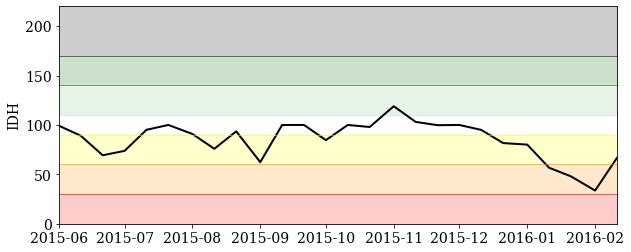

In [19]:
plt.figure(figsize=(10,4))
plt.plot(fechas_ppt_dec, IDH_pixel, color='k', lw=2)
plt.xlim(fechas_ppt_dec[0], fechas_ppt_dec[-1])
plt.ylabel('IDH')
plt.ylim(0,220)
plt.axhline(30, color='red', lw=0.5)
plt.axhline(60, color='darkorange', lw=0.5)
plt.axhline(90, color='yellow', lw=0.5)
plt.axhline(140, color='forestgreen', lw=0.5)
plt.axhline(170, color='darkgreen', lw=0.5)

plt.fill_between(fechas_ppt_dec, 0, 30, color='red', alpha=0.2)
plt.fill_between(fechas_ppt_dec, 30, 60, color='darkorange', alpha=0.2)
plt.fill_between(fechas_ppt_dec, 60, 90, color='yellow', alpha=0.2)
plt.fill_between(fechas_ppt_dec, 110, 140, color='forestgreen', alpha=0.1)
plt.fill_between(fechas_ppt_dec, 140, 170, color='darkgreen', alpha=0.2)
plt.fill_between(fechas_ppt_dec, 170, 220, color='black', alpha=0.2);